# Imports

In [1]:
import numpy as np
import pandas as pd
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import tensorflow as tf
from   tensorflow.keras.callbacks import ModelCheckpoint

# Model Training

## Get Encoded data

In [2]:
model_df = pd.read_csv("charity_data.2.preprocess.one_hot_encoded.csv")

In [3]:
row_count = model_df.IS_SUCCESSFUL.count()
print(f"The number of rows in the data set is: {row_count}")

The number of rows in the data set is: 34299


## Model Parameters

In [4]:
# The neural network model is designed to 
# test the model by setting a threshold
# to remove ASK_AMT outlier values

feature_ask_amt_outlier_le_threshold = 1000000000000


# The neural network model is designed to 
# test the model with various binning 
# thresholds for the features
# 
# APPLICATION_TYPE
# CLASSIFICATION


# Bucketing row count thresholds
feature_appl_bucketing_le_row_cnt = 10

feature_class_bucketing_le_row_cnt = 4

hidden_layer_1_nodes   = 75
hidden_layer_1_act_func = "relu"

hidden_layer_2_nodes   = 150
hidden_layer_2_act_func = "relu"

hidden_layer_3_nodes   = 10
hidden_layer_3_act_func = "relu"

output_layer_nodes = 1
output_layer_act_func = "sigmoid"

epochs = 200

### Remove target ASK_AMT Outliers

In [5]:
model_df = model_df[(model_df["ASK_AMT"] <= feature_ask_amt_outlier_le_threshold)]

In [6]:
row_count_removed = row_count - model_df.IS_SUCCESSFUL.count()
print(f"Eliminating ASK_AMT outliers over {feature_ask_amt_outlier_le_threshold} dollars removed {row_count_removed} rows")

Eliminating ASK_AMT outliers over 1000000000000 dollars removed 0 rows


### Bucketing features APPLICATION_TYPE and CLASSIFICATION

In [7]:
def remapp(classification, remap_class_list):
    if classification in remap_class_list:
        return "Other"
    return classification

In [8]:
def set_feature_binning(feature_Name, bucketing_le_row_cnt):
    ## if binning row count threshold is > 0 bin feature
    if bucketing_le_row_cnt > 0:
        # Get feature unique classification row counts
        feature_cat_filt_row_cnt_ser = model_df[feature_Name].value_counts()
        
        # Filter classification values that have a row counts that
        # are less than or equal to the binning threshold row count
        feature_cat_filt_row_cnt_ser = feature_cat_filt_row_cnt_ser[(feature_cat_filt_row_cnt_ser[:] <= bucketing_le_row_cnt)]
        
        # Set feature catigory value to other for feature 
        # catigory values that have been binned
        model_df[feature_Name] = model_df[feature_Name].apply(remapp, args=[feature_cat_filt_row_cnt_ser.index])
        
        ## get 
        feature_updated_cat_count = model_df[feature_Name].nunique()
        print(f"Feature: {feature_Name} bucketing threshold {bucketing_le_row_cnt} updated catigory count: {feature_updated_cat_count}")

In [9]:
unique_class_count = model_df["APPLICATION_TYPE"].nunique()
print(f"The number of unique catigory values for the feature APPLICATION_TYPE is {unique_class_count}")

The number of unique catigory values for the feature APPLICATION_TYPE is 17


In [10]:
unique_class_count = model_df["CLASSIFICATION"].nunique()
print(f"The number of unique catigory values for the feature CLASSIFICATION is {unique_class_count}")

The number of unique catigory values for the feature CLASSIFICATION is 71


In [11]:
set_feature_binning("APPLICATION_TYPE", feature_appl_bucketing_le_row_cnt)

Feature: APPLICATION_TYPE bucketing threshold 10 updated catigory count: 13


In [12]:
set_feature_binning("CLASSIFICATION", feature_class_bucketing_le_row_cnt)

Feature: CLASSIFICATION bucketing threshold 4 updated catigory count: 38


### Encoding Catigorical Fields APPLICATION_TYPE and CLASSIFICATION After Bucketing

In [13]:
# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False, dtype=np.int64)

# Fit and transform the OneHotEncoder using the categorical variable list
encoded_df = pd.DataFrame(encoder.fit_transform(model_df[["APPLICATION_TYPE","CLASSIFICATION"]]))

# Add the encoded variable names to the DataFrame
encoded_df.columns = encoder.get_feature_names(["APPLICATION_TYPE","CLASSIFICATION"])

In [14]:
# Merge one-hot encoded features and drop the originals
model_df.drop(["APPLICATION_TYPE","CLASSIFICATION"],1, inplace=True)
model_df = model_df.merge(encoded_df,left_index=True, right_index=True)

In [15]:
# Display one hot encoding for features APPLICATION_TYPE and CLASSIFICATION
for column_name in model_df.columns:
    if column_name[0:16] == "APPLICATION_TYPE" or column_name[0:14] == "CLASSIFICATION":
        print(f"The column:[{column_name}] has [{len(model_df[column_name].unique())}] values")

The column:[APPLICATION_TYPE_Other] has [2] values
The column:[APPLICATION_TYPE_T10] has [2] values
The column:[APPLICATION_TYPE_T12] has [2] values
The column:[APPLICATION_TYPE_T13] has [2] values
The column:[APPLICATION_TYPE_T19] has [2] values
The column:[APPLICATION_TYPE_T2] has [2] values
The column:[APPLICATION_TYPE_T3] has [2] values
The column:[APPLICATION_TYPE_T4] has [2] values
The column:[APPLICATION_TYPE_T5] has [2] values
The column:[APPLICATION_TYPE_T6] has [2] values
The column:[APPLICATION_TYPE_T7] has [2] values
The column:[APPLICATION_TYPE_T8] has [2] values
The column:[APPLICATION_TYPE_T9] has [2] values
The column:[CLASSIFICATION_C1000] has [2] values
The column:[CLASSIFICATION_C1200] has [2] values
The column:[CLASSIFICATION_C1230] has [2] values
The column:[CLASSIFICATION_C1235] has [2] values
The column:[CLASSIFICATION_C1237] has [2] values
The column:[CLASSIFICATION_C1238] has [2] values
The column:[CLASSIFICATION_C1240] has [2] values
The column:[CLASSIFICATION

### Scale ASK_AMT feature

In [16]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_ASK_AMT_scaler = scaler.fit(model_df["ASK_AMT"].values.reshape(-1,1))

# Scale the data
model_df["ASK_AMT"] = X_ASK_AMT_scaler.transform(model_df["ASK_AMT"].values.reshape(-1,1))

### Create training and testing data sets

In [17]:
# Split our preprocessed data into our features and target arrays
y = model_df["IS_SUCCESSFUL"].values
X = model_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Train neural network

In [18]:
# Define the model - deep neural net
number_input_features = len(X_train[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add( tf.keras.layers.Dense(units=hidden_layer_1_nodes, input_dim=number_input_features, activation=hidden_layer_1_act_func))

# Second hidden layer add if node count > 0
if hidden_layer_2_nodes > 0:
    nn.add(tf.keras.layers.Dense(units=hidden_layer_2_nodes, activation=hidden_layer_2_act_func))

# Third hidden layer add if node count > 1
if hidden_layer_3_nodes > 0:
    nn.add(tf.keras.layers.Dense(units=hidden_layer_3_nodes, activation=hidden_layer_3_act_func))
    
# Output layer
nn.add(tf.keras.layers.Dense(units=output_layer_nodes, activation=output_layer_act_func))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 75)                5775      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               11400     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1510      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 18,696
Trainable params: 18,696
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=epochs)

Epoch 1/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5673 - accuracy: 0.7224
Epoch 2/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5512 - accuracy: 0.7311
Epoch 3/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5473 - accuracy: 0.7332
Epoch 4/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5452 - accuracy: 0.7331
Epoch 5/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5438 - accuracy: 0.7347
Epoch 6/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5433 - accuracy: 0.7371
Epoch 7/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5417 - accuracy: 0.7362
Epoch 8/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5397 - accuracy: 0.7381
Epoch 9/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5394 - accuracy: 0.7378
Epoch 10/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5380 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5248 - accuracy: 0.7450
Epoch 82/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5244 - accuracy: 0.7448
Epoch 83/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5243 - accuracy: 0.7446
Epoch 84/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5251 - accuracy: 0.7452
Epoch 85/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5249 - accuracy: 0.7446
Epoch 86/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5242 - accuracy: 0.7453
Epoch 87/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5244 - accuracy: 0.7445
Epoch 88/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5242 - accuracy: 0.7454
Epoch 89/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5241 - accuracy: 0.7447
Epoch 90/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5240 - accuracy: 

804/804 [==============================] - 1s 1ms/step - loss: 0.5216 - accuracy: 0.7464
Epoch 161/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5219 - accuracy: 0.7465
Epoch 162/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5220 - accuracy: 0.7460
Epoch 163/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5218 - accuracy: 0.7463
Epoch 164/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5222 - accuracy: 0.7457
Epoch 165/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5217 - accuracy: 0.7453
Epoch 166/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5209 - accuracy: 0.7460
Epoch 167/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5217 - accuracy: 0.7465
Epoch 168/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5227 - accuracy: 0.7460
Epoch 169/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5217 - a

### Accuracy and Error Data for Model Training

In [21]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

Model loss grapth


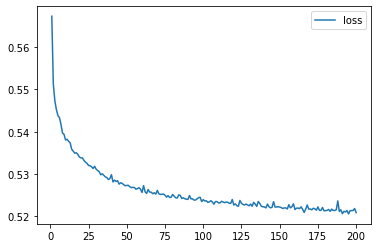

In [22]:
# Plot the loss
print("Model loss grapth")
history_df.plot(y="loss")

Model accuracy grapth


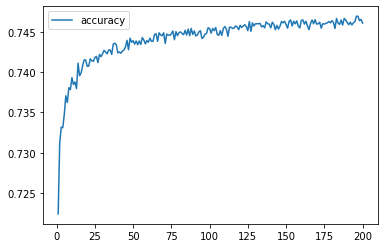

In [23]:
# Plot the accuracy
print("Model accuracy grapth")
history_df.plot(y="accuracy")

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Test set statistics:  Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6721 - accuracy: 0.7265
Test set statistics:  Loss: 0.6721292734146118, Accuracy: 0.7265306115150452


### Save Model if Accuracy >= 0.75

In [25]:
# Export our model to HDF5 file
if model_accuracy >= 0.75:
    nn.save("charity_analysis_trained.h5")